In [1]:
import numpy as np
from IPython import display

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_hidden = 15
num_dxs = 15
num_findings = 10
num_samples = 200

In [4]:
def update_params(X,Y,H,W,V,reg_p):
    Phi = H.dot(W)
    B_Phi = .25*Phi-np.reciprocal(1+np.exp(-Phi))
    X_tilde = 4*(X+B_Phi)
    H_1 = X_tilde.dot(W.T)
    Sig_W = 4*((H**2).sum(axis=0)[:,np.newaxis]) + reg_p*np.ones(W.shape)
    W_ = H.T.dot(X_tilde)*np.reciprocal(Sig_W)
    
    
    Psi_pre = H.dot(V)
    Psi = diff_op(Psi_pre)
    B_Psi = .25*Psi-np.reciprocal(1+np.exp(-Psi))
    Y_tilde = 4*(Y+B_Psi)
    H_2 = diff_op_T(Y_tilde).dot(V.T)
    num_dx=V.shape[1]
    Sig_V = 4*((H**2).sum(axis=0)[:,np.newaxis]*(2*(num_dx-1)))+reg_p*np.ones(V.shape)
    V_ = H.T.dot(diff_op_T(Y_tilde))*np.reciprocal(Sig_V)
    V_ = np.eye(H.shape[1])
    
    Sig_H = reg_p*np.ones(H.shape)
    Sig_H += 4*(W**2).sum(axis=1)[np.newaxis,:]
    Sig_H += 4*(2*(num_dx-1))*(V**2).sum(axis=1)[np.newaxis,:]
    H_ = (H_1+H_2)*np.reciprocal(Sig_H)
    
    return (H_,Sig_H), (W_,Sig_W), (V_,Sig_V)
    
    
def update_params(X,Y,H,W,V,reg_p):
    Phi = H.dot(W)
    B_Phi = .25*Phi-np.reciprocal(1+np.exp(-Phi))
    X_tilde = (X+B_Phi)
    Sig_W = 4*((H**2).sum(axis=0)[:,np.newaxis]) + reg_p*np.ones(W.shape)
    W_ = H.T.dot(X_tilde)*np.reciprocal(Sig_W)
    
    H_ = H
    Sig_H=np.eye(*H.shape)
    V_ = V
    Sig_V=np.eye(*V.shape)
    return (H_,Sig_H), (W_,Sig_W), (V_,Sig_V)


    
def update_params(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,reg_h,reg_p):
    num_samples, num_hidden = H.shape
    _, num_findings = W.shape
    _, num_dxs = V.shape
    
    Xi = np.sqrt(Sig_H.dot(Sig_W+(W**2))+(H**2).dot(Sig_W)+(H.dot(W))**2)
    Eta2 = diff_op(H.dot(V))**2+ diff_op2((Sig_H+H**2).dot(Sig_V))+np.tensordot(Sig_H,diff_op(V)**2,axes=(1,0))
    Eta = np.sqrt(Eta2)
    #Eta = np.sqrt(diff_op2(Sig_H.dot(Sig_V+(V**2))+(H**2).dot(Sig_V)+(H.dot(V))**2))
    
    assert np.isfinite(Xi).all()
    assert np.isfinite(Eta).all()
    
    L = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,reg_h,reg_p)
    
    
    W, Sig_W = update_weights(X,W,H,Xi,np.zeros(W.shape),reg_p)
    
    LW = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,reg_h,reg_p)
    
    diff_op_mat = diff_op(np.eye(V.shape[1]))
    H_ext = np.einsum('ij,klm->ilmjk',H,diff_op_mat).reshape([num_samples,-1])
    V_resh,Sig_V_resh = update_weights(Y.reshape([-1]),
                                       V.reshape([-1]),
                                       H_ext.reshape([-1,len(V.reshape([-1]))]),
                                       Eta.reshape([-1]),
                                       np.zeros(V.shape).reshape([-1]),
                                       reg_p)
    V = V_resh.reshape(V.shape)
    Sig_V = Sig_V_resh.reshape(V.shape)
    
    LV = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,reg_h,reg_p)
    
    
    W_ext = np.hstack([W,diff_op(V).reshape([num_hidden,-1])])
    Xi_ext = np.hstack([Xi,Eta.reshape([num_samples,-1])])
    T_ext = np.hstack([X,Y.reshape([num_samples,-1])])
    
    H_T, Sig_H_T = update_weights(T_ext.T,H.T,W_ext.T,Xi_ext.T,np.zeros(H.T.shape),reg_h)
    H, Sig_H = (H_T.T,Sig_H_T.T)
    
    LH = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,reg_h,reg_p)
    
    return (H,Sig_H), (W,Sig_W), (V,Sig_V), (L,LW,LV,LH)

def update_weights(T,W,X,Xi,W_0,reg):
    """Update the weight matrix
    T = observed values
    W = weights (at current iteration of VB)
    X = features
    Xi = JJ positions (at current iteration of VB)
    W_0 = prior bias for W
    reg = regularization strength
    
    we assume T ~ Bernouilli(sigmoid(XW))
    returns (W,Sig_W)
    where W are the updated weight values and Sig_W are the current variances of those weight values.
    """
    #print("T: %s, W: %s, X: %s, Xi: %s, W_0: %s" % (T.shape,W.shape,X.shape,Xi.shape,W_0.shape))
    k = (len(X.shape)+len(W.shape)-len(T.shape))//2 # number of indices to contract over.
    S_W_0_inv = reg*np.ones(W.shape)
    
    lamXi = lambdoid(Xi)
    assert np.isfinite(lamXi).all()
    
    #print("k:%d, X: %s, Xi: %s" %(k,X.shape,Xi.shape))
    X2lamXi = np.tensordot((X**2).T,lamXi,k)
    assert np.isfinite(X2lamXi).all()
    
    S_W_inv_ = S_W_0_inv + 2*X2lamXi
    S_W_ = np.reciprocal(S_W_inv_)
    assert np.isfinite(S_W_).all()
    
    term1 = np.tensordot(X.T, T-0.5-2*lamXi*np.tensordot(X,W,k),k)
    term2 = 2*W*X2lamXi
    
    assert np.isfinite(term1).all()
    assert np.isfinite(term2).all()
    
    W_ = S_W_*(S_W_0_inv*W_0+term1+term2)
    
    assert np.isfinite(W_).all()
    return W_, S_W_
    

In [5]:
def diff_op(HV,max_dxs=None):
    return np.tile(HV[:,:,np.newaxis],[1,1,num_dxs])-np.tile(HV[:,np.newaxis,:],[1,num_dxs,1])

def diff_op2(HV,max_dxs=None):
    return np.tile(HV[:,:,np.newaxis],[1,1,num_dxs])+np.tile(HV[:,np.newaxis,:],[1,num_dxs,1])
    
def diff_op_T(HTY):
    return HTY.sum(axis=2)-HTY.sum(axis=1)

In [6]:
HV = np.random.normal(size=[num_samples,num_dxs])
HVV = diff_op(HV)

In [7]:
HV

array([[-1.02439413,  0.12656084,  1.25088788, ..., -0.20153203,
         0.00913718, -0.0852908 ],
       [ 0.67231831,  1.34685014, -0.78314067, ..., -0.56439353,
        -0.81900889, -0.45923093],
       [ 0.66084664, -1.19829293, -0.02595304, ..., -0.4320336 ,
        -2.14310166, -0.75414048],
       ..., 
       [-0.50549474,  0.38201701, -0.50142778, ...,  0.51062918,
         1.12285492, -1.4585725 ],
       [-1.24426165, -0.50257691,  0.26829671, ...,  0.38917808,
        -0.16982301,  0.44071432],
       [ 2.12042421,  1.57615959,  0.96359145, ...,  1.08614701,
         0.48561671, -0.19545133]])

In [8]:
HV = np.random.randint(low=-5,high=5,size=[num_samples,num_dxs])
HVV = diff_op(HV)
for k in range(num_samples):
    for i in range(num_dxs):
        for j in range(num_dxs):
            if i==j:
                assert(HVV[k,i,j]==0)
            else:
                assert(HVV[k,i,j]==HV[k,i]-HV[k,j])

HTY = np.random.randint(low=-5,high=5,size=[num_samples,num_dxs,num_dxs])
HHTY = diff_op_T(HTY)
assert((np.einsum('ijk,pjk->ip',HVV,HTY)==HV.dot(HHTY.T)).all())

In [9]:
def KLDivergence(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1)
    Sig2inv = np.linalg.inv(Sig2)
    Sig2invSig1 = Sig2inv.dot(Sig1)
    return 0.5*(-np.linalg.slogdet(Sig2invSig1)[1]-d+np.trace(Sig2invSig1)+(m2-m1).T.dot(Sig2inv.dot(m2-m1)))

def KLDivergence_diag(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1.flatten())
    Sig2inv = np.reciprocal(Sig2)
    Sig2invSig1 = Sig2inv*Sig1
    return 0.5*(-np.log(Sig2invSig1).sum()-d+Sig2invSig1.sum()+(((m2-m1)**2)*Sig2inv).sum())

In [10]:
def log_1_add_exp(x):
    mask = x<0
    nmask = np.logical_not(mask)
    ans = np.zeros_like(x)
    ans[mask] = np.log1p(np.exp(x[mask]))
    ans[nmask] = np.log1p(np.exp(-x[nmask]))+x[nmask]
    return ans

def lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,reg_h,reg_p):
    KLH = KLDivergence_diag(H,Sig_H,np.zeros_like(H),np.ones_like(H)/reg_h)
    KLW = KLDivergence_diag(W,Sig_W,np.zeros_like(W),np.ones_like(W)/reg_p)
    KLV = KLDivergence_diag(V,Sig_V,np.zeros_like(V),np.ones_like(V)/reg_p)
    HW = H.dot(W)
    HW2 = Sig_H.dot(Sig_W+W**2)+(H**2).dot(Sig_W)+HW**2
    lamXi = lambdoid(Xi)
    lseW = (lamXi*(HW2-Xi**2)+0.5*(HW-Xi)+log_1_add_exp(Xi)).sum()
    HVF = diff_op(H.dot(V))
    HVF2 = diff_op2(Sig_H.dot(Sig_V+V**2)+(H**2).dot(Sig_V))+HVF**2 
    lamEta = lambdoid(Eta)
    lseV = (lamEta*(HVF2-Eta**2)+0.5*(HVF-Eta)+log_1_add_exp(Eta)).sum()
    e_log_likelihood = (X*HW).sum()+(Y*HVF).sum()-lseW-lseV
    return KLH+KLW+KLV-e_log_likelihood

In [11]:
def lambdoid(xi):
    from scipy.special import exprel
    return 0.25*exprel(xi)/(np.exp(xi)+1)

In [12]:
def sigmoid(eta):
    return 1/(1+np.exp(-eta))

In [13]:
_W = np.random.randn(num_dxs, num_findings)

In [14]:
def bernoulli(p):
    rands = np.random.rand(*np.array(p).shape)
    return np.array(rands < p,dtype=np.float)

In [15]:
def generate_cases(num_dxs, num_findings, avg_ddx_length, w, num_samples=1):
    h = np.random.randn(num_samples,num_dxs)
    y = bernoulli(sigmoid(diff_op(h)))
    x = bernoulli(sigmoid(h.dot(w)))
    return x,y,h

In [16]:
X,Y,H_0 = generate_cases(num_dxs=num_dxs, num_findings=num_findings, w=_W, avg_ddx_length=1, num_samples=num_samples)

In [17]:
alpha = 0.003
reg_p = 2
fig = plt.figure(1)
def fit(X, Y, num_hidden, reg_p):
    num_samples, num_findings = X.shape
    num_dxs = Y.shape[1]
    H = np.random.randn(num_samples, num_hidden)/np.sqrt(float(num_samples+num_hidden))
    H = np.copy(H_0)
    W = np.random.randn(num_hidden, num_findings)/np.sqrt(float(num_hidden+num_findings))
    V = np.random.randn(num_hidden, num_dxs)/np.sqrt(float(num_hidden+num_dxs*num_dxs))
    Sig_H = 0.001*np.ones(H.shape)
    Sig_W = 0.001*np.ones(W.shape)
    Sig_V = 0.001*np.ones(V.shape)
    max_h = [abs(H).max()]
    max_w = [abs(W).max()]
    max_v = [abs(V).max()]
    L = []
    for i in range(2000):
        (HH, Sig_H), (WW,Sig_W), (VV,Sig_V), Ls = update_params(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,reg_p,reg_p)
        H = H*(1-alpha) + alpha*HH
        W = W*(1-alpha) + alpha*WW
        V = V*(1-alpha) + alpha*VV
        max_h.append(abs(H).max())
        max_w.append(abs(W).max())
        max_v.append(abs(V).max())
        L += list(Ls)
        #print("iteration %d" % i)
        
        plt.gcf().clf()
        plt.subplot(311)
        plt.plot(range(len(L)),L)
        data_h = H_0.dot(_W).flatten()
        data_v = H_0.flatten()
        pred_h = H.dot(W).flatten()
        pred_v = H.dot(V).flatten()
        plt.subplot(312)
        plt.scatter(data_h,pred_h)
        plt.subplot(313)
        plt.scatter(data_v,pred_v)
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
    return (H, Sig_H), (W,Sig_W), (V,Sig_V), max_h, max_w, max_v, L

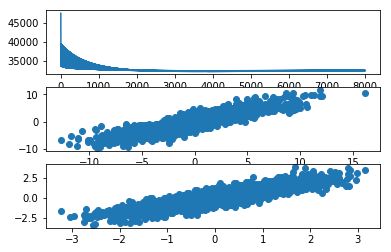

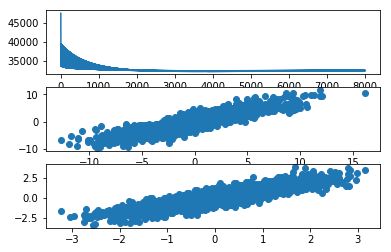

In [18]:
(H, Sig_H), (W,Sig_W), (V,Sig_V), max_h, max_w, max_v, Ls = fit(X, Y, num_hidden,.1)

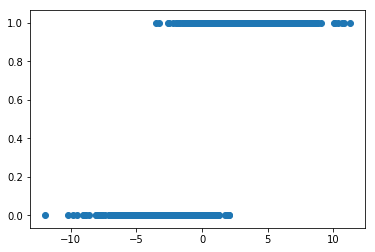

In [58]:
plt.scatter(H.dot(W).flatten(),X.flatten())

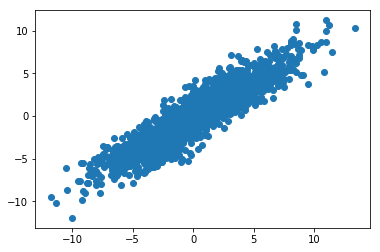

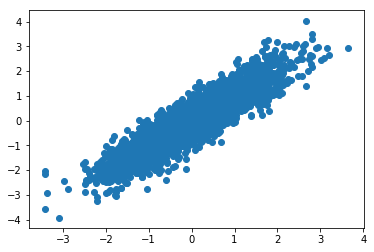

In [59]:
data_h = H_0.dot(_W).flatten()
data_v = H_0.flatten()
pred_h = H.dot(W).flatten()
pred_v = H.dot(V).flatten()
plt.scatter(data_h,pred_h)
plt.show()
plt.scatter(data_v,pred_v)

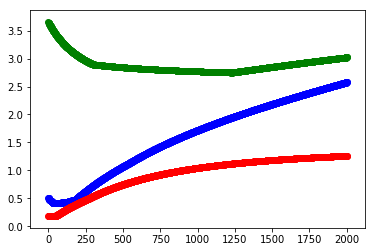

In [60]:
plt.scatter(range(len(max_h)),max_w, color='blue')
plt.scatter(range(len(max_h)),max_v, color='red')
plt.scatter(range(len(max_h)),max_h, color='green')

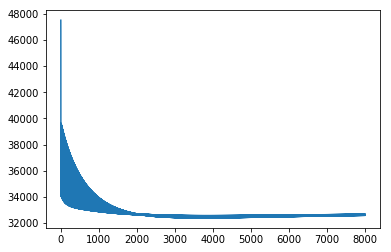

In [61]:
n=-1
plt.plot(range(len(Ls[:n])),Ls[:n])

In [ ]:
H-H_0